In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
path.insert(0, '../src')
from setup import data_setup
from data_generator import DataGenerator
from model_trainer import ModelTrainer

In [3]:
dg = data_setup()
norm_data = dg.df()

In [4]:
norm_data.head()

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks
0,0 2644.03673 1 3505.01837 2 ...,0 73874 1 1234 2 138 3 ...,0106301.cas,0.387425,-0.275047,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2644.0367300000003, 73874), (3505.0183700000..."
1,0 2647.00072 1 3508.99491 2 ...,0 49864 1 1034 2 168 3 ...,0107316.cas,0.387337,-0.278302,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2647.00072, 49864), (3508.9949100000003, 103..."
2,0 1973.87665 1 2049.07068 2 2122.0...,0 23352 1 74717 2 10387 3 94...,0110203.cas,0.378938,-0.271015,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(1973.87665, 23352), (2049.0706800000003, 747..."
3,0 672.00298 1 891.90543 2 197...,0 34398 1 304 2 2223 3 ...,0110212.cas,0.379297,-0.269824,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(672.00298, 34398), (891.90543, 304), (1970.9..."
4,0 2726.98153 1 3594.53649 2 ...,0 42995 1 602 2 151 3 ...,0116511.cas,0.383481,-0.302161,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2726.98153, 42995), (3594.53649, 602), (4265..."


In [5]:
def get_frags(loc='../data/FragLibData32_Converted2010 (1)/Fragment Table.csv'):
    df = pd.read_csv(loc)
    a = list(df.columns[0:])
    a[0] = float(a[0])
    a[-1] = int(a[-1])
    a[-2] = a[-2][0]
    df.columns = ['FragmentMass', 'FragmentLabel', 'Isotopes', 'Formula', 'FragmentID']
    b = {'FragmentMass': a[0], 'FragmentLabel': a[1], 'Isotopes':a[2] , 'Formula':a[3],'FragmentID':a[4]}
    df = pd.concat([pd.DataFrame(b, index=[0]), df], sort=False)
    return df

In [6]:
frags = get_frags()
frags.reset_index(drop=True, inplace=True)

In [7]:
frags.head()

,FragmentMass,FragmentLabel,Isotopes,Formula,FragmentID
0,1.007820,H,1H1,H,1
1,2.014100,H,2H1,2H,2
2,3.016029,He,3He1,3He,3
3,4.002603,He,4He1,He,4
4,6.015120,Li,6Li1,6Li,5


In [8]:
spec = pd.read_csv('../data/PET_rrCalibd_Pos-37-012.csv')['SOFH']

In [9]:
slope = float(spec[10].split(': ')[1])
offset = float(spec[11].split(': ')[1])
time = float(spec[5].split(': ')[1])
binsize = float(spec[14].split(': ')[1])
peaks = spec[20:].copy().reset_index(drop=True).apply(float)

In [10]:
from data_transformation import mass_formula
peaks_perfect = peaks.apply(mass_formula, args=(binsize, time, slope, offset))

In [11]:
spots = frags['FragmentMass']

In [12]:
def get_frags_dists(masses, frags, thresh=0.005):
    '''
    Determines which elemental / compound masses correspond
    to actual spectra masses and returns both the fragments
    and the distance between each fragment and its related mass in
    the given spectra.
    '''
    found_masses = []
    found_frags = []
    dists = []
    for mass in masses:
        not_found = True
        i = (len(frags)) // 2
        floor = 0
        cieling = len(frags) - 1

        def is_findable():
            if abs(floor - cieling) <= 1:
                return False
            return True
        
        while not_found:
            dist = frags[i] - mass
            if abs(dist) < thresh:
                not_found = False
                i = get_closest(i, frags, mass)
                found_masses.append(mass)
                found_frags.append(frags[i])
                dists.append(abs(frags[i] - mass))
            elif dist > 0:
                not_found = is_findable()
                cieling = i
                num = abs(floor - i)
                if num != 1:
                    i -= abs(floor - i) // 2
                else:
                    i -= 1
            else:
                not_found = is_findable()
                floor = i
                num = abs(cieling - i)
                if num != 1:
                    i += abs(cieling - i) // 2
                else:
                    i += 1
    return found_masses, found_frags, dists

In [13]:
def get_closest(i, frags, mass):
    d = abs(frags[i] - mass)
    if len(frags) > i + 1 and d > abs(frags[i + 1] - mass):
        i = get_closest(i + 1, frags, mass)
    elif i - 1 >= 0 and d > abs(frags[i - 1] - mass):
        i = get_closest(i - 1, frags, mass)
    return i

In [82]:
masses, fragments, distances = get_frags_dists(peaks_perfect, spots, thresh=0.007)
print('num: ', len(masses))
print('mean dist: ', np.mean(distances))

num:  182
mean dist:  0.0012963278514642824


In [83]:
offset_add = offset + offset * .001
peaks_add_offset = peaks.apply(mass_formula, args=(binsize, time, slope, offset_add))

In [86]:
masses, fragments, distances = get_frags_dists(peaks_add_offset, spots, thresh=0.007)
print('num: ', len(masses))
print('mean dist: ', np.mean(distances))

num:  168
mean dist:  0.002526796961334445


In [76]:
offset_sub = offset - offset * .001
peaks_sub_offset = peaks.apply(mass_formula, args=(binsize, time, slope, offset_sub))

In [80]:
masses, fragments, distances = get_frags_dists(peaks_sub_offset, spots, thresh=0.007)
print('num: ', len(masses))
print('mean dist: ', np.mean(distances))

num:  148
mean dist:  0.0018591080592085267


In [38]:
training_data['target'] = erred['target']

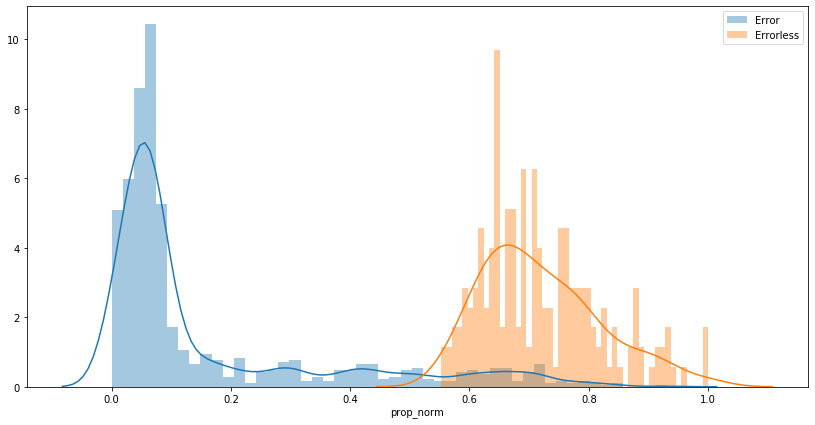

In [39]:
plt.figure(figsize=(14, 7))
sns.distplot(training_data[training_data['target']==1]['prop_norm'], bins=50, label='Error')
sns.distplot(training_data[training_data['target']==0]['prop_norm'], bins=50, label='Errorless')
plt.legend()

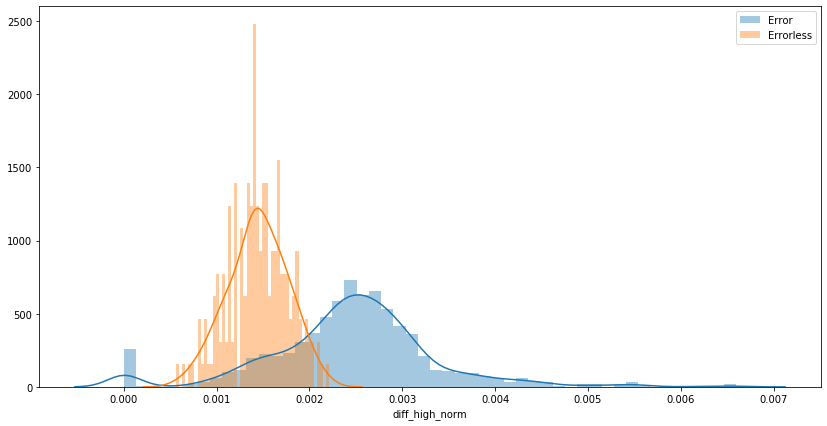

In [40]:
plt.figure(figsize=(14, 7))
sns.distplot(training_data[training_data['target']==1]['diff_high_norm'], bins=50, label='Error')
sns.distplot(training_data[training_data['target']==0]['diff_high_norm'], bins=50, label='Errorless')
plt.legend()

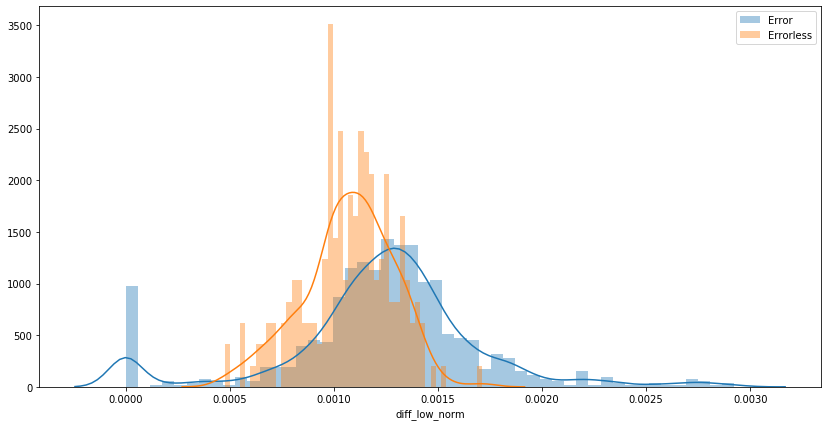

In [41]:
plt.figure(figsize=(14, 7))
sns.distplot(training_data[training_data['target']==1]['diff_low_norm'], bins=50, label='Error')
sns.distplot(training_data[training_data['target']==0]['diff_low_norm'], bins=50, label='Errorless')
plt.legend()

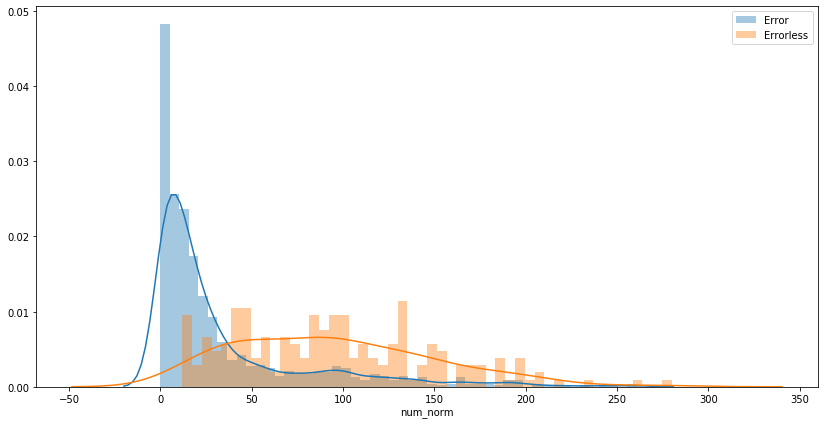

In [42]:
plt.figure(figsize=(14, 7))
sns.distplot(training_data[training_data['target']==1]['num_norm'], bins=50, label='Error')
sns.distplot(training_data[training_data['target']==0]['num_norm'], bins=50, label='Errorless')
plt.legend()

In [19]:
original_data = dg.calibrated_df()

In [20]:
dists_low_thresh = []
dists_high_thresh = []
nums = []
props = []
for row in original_data.itertuples():
    masses, _, distances = get_frags_dists(row.masses, spots, thresh=0.003)
    nums.append(len(masses))
    props.append(len(masses) / len(row.masses))
    dists_low_thresh.append(np.mean(distances))
    _, _, distances = get_frags_dists(row.masses, spots, thresh=0.007)
    dists_high_thresh.append(np.mean(distances))

In [21]:
original_data['avg_dist_frags_low_thresh'] = dists_low_thresh
original_data['avg_dist_frags_high_thresh'] = dists_high_thresh
original_data['num_indentified_frags'] = nums
original_data['proportions_peaks_identified'] = props
original_data['diff'] = original_data['avg_dist_frags_high_thresh'] - original_data['avg_dist_frags_low_thresh']

In [22]:
def get_calibration(data, modifier=.5, prop_thresh=0.65):
    calibs = []
    for row in data.itertuples():
        if row.diff < row.avg_dist_frags_low_thresh * modifier:
            if row.proportions_peaks_identified > prop_thresh:
                calibs.append(1)
            else:
                calibs.append(0)
        else:
            calibs.append(0)
    return calibs

In [23]:
original_data['calibration'] = get_calibration(original_data, .5, .55)

In [24]:
def get_ranges(mass_lists, length, max = 235):
    '''
    Computes no mans land spectras.
    '''
    ranges = [[x, x + 1] for x in range(length)]
    for masses in mass_lists:
        for mass in masses:
            i = int(mass)
            if mass < 235.043933:
                if round(mass) == i + 1 and mass < ranges[i][1]:
                    ranges[i][1] = mass
                elif round(mass) == i and mass > ranges[i][0]:
                    ranges[i][0] = mass
            else:
                ranges[i][0] = mass
                ranges[i][1] = i + .9871
    return ranges

In [25]:
original_data['target'] = 0

In [26]:
original_data.head()

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,mass_channels,masses,intensities,avg_dist_frags_low_thresh,avg_dist_frags_high_thresh,num_indentified_frags,proportions_peaks_identified,diff,calibration,target
0,0 2644.03673 1 3505.01837 2 ...,0 73874 1 1234 2 138 3 ...,0106301.cas,0.387425,-0.275047,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2644.0367300000003, 73874), (3505.0183700000...","[2644.0367300000003, 3505.0183700000002, 4162....","[1.0067357827001502, 2.0154136848060986, 3.019...","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...",0.001210,0.002547,51,0.398438,0.001337,0,0
1,0 2647.00072 1 3508.99491 2 ...,0 49864 1 1034 2 168 3 ...,0107316.cas,0.387337,-0.278302,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2647.00072, 49864), (3508.9949100000003, 103...","[2647.00072, 3508.9949100000003, 4164.59326000...","[1.0025002148906825, 2.0105384152423085, 3.009...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...",0.001230,0.002755,17,0.129771,0.001525,0,0
2,0 1973.87665 1 2049.07068 2 2122.0...,0 23352 1 74717 2 10387 3 94...,0110203.cas,0.378938,-0.271015,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(1973.87665, 23352), (2049.0706800000003, 747...","[1973.87665, 2049.0706800000003, 2122.01224, 2...","[11.9915465622805, 12.996908473240481, 14.0108...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...",0.001164,0.002964,7,0.388889,0.001800,0,0
3,0 672.00298 1 891.90543 2 197...,0 34398 1 304 2 2223 3 ...,0110212.cas,0.379297,-0.269824,0.0,4.992,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(672.00298, 34398), (891.90543, 304), (1970.9...","[672.00298, 891.90543, 1970.94521, 2046.11295,...","[1.0051638174978783, 2.0134261084051874, 11.98...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...",0.001326,0.002605,41,0.379630,0.001279,0,0
4,0 2726.98153 1 3594.53649 2 ...,0 42995 1 602 2 151 3 ...,0116511.cas,0.383481,-0.302161,0.0,1.248,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(2726.98153, 42995), (3594.53649, 602), (4265...","[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[1.0058658675679875, 2.011083088854326, 3.0245...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...",0.001521,0.003114,41,0.336066,0.001593,0,0


In [27]:
from data_transformation import generate_data
erred = original_data[original_data['calibration']==1].copy()
df = generate_data(original_data, 2, 2, True, [0.3, 0.6, 1], True, True).drop(['err_prop_offset', 'err_prop_slope'], axis=1)
df['target'] = 1
erred = pd.concat([erred, df], axis=0)
dg.set_df(erred)
erred = dg.calibrated_df()
erred.reset_index(drop=True, inplace=True)

In [28]:
from data_transformation import get_isotope_data, get_hydrocarbs, get_suspicious_peaks
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
erred['num_peaks_nml'] = erred['masses'].apply(get_suspicious_peaks, args=(ranges,)).apply(len)
erred['num_peaks_not_nml'] = erred['masses'].apply(len) - erred['num_peaks_nml']
erred['prop_peaks_nml'] = erred['num_peaks_nml'] / erred['masses'].apply(len)

In [29]:
from data_transformation import mass_formula
def get_cols(data, amt, err=False):
    n = 1
    if err:
        n = 3
    cols = [[[] for num in range(n)] for num in range(4)]
    for row in data.itertuples():
        mass_lists = [row.masses]
        if err:
            for num in [1, -1]:
                x = pd.Series(row.precise_channels)
                y = x.apply(mass_formula, args=(row.SpecBinSize,
                                            row.StartFlightTime,
                                            row[4],
                                            row.MassOffset + num * row.MassOffset * amt))
                mass_lists.append(y)
        for i in range(n):
            a, b, c, d = get_stats(mass_lists[i])
            cols[0][i].append(a) # num masses
            cols[1][i].append(b) # proportion
            cols[2][i].append(c) # low thresh
            cols[3][i].append(d) # high thresh
    return cols

In [30]:
def get_stats(row_masses):
    masses, _, distances1 = get_frags_dists(row_masses, spots, thresh=0.003)
    _, _, distances2 = get_frags_dists(row_masses, spots, thresh=0.007)
    x = 0
    if len(distances1) > 0:
        x = np.mean(distances1)
    y = 0
    if len(distances2) > 0:
        y = np.mean(distances2)
    return len(masses), len(masses) / len(row_masses), x, y

In [31]:
cols = get_cols(erred, .01, err=True)

In [32]:
from sklearn.model_selection import train_test_split
d = {'num_norm': cols[0][0], 'prop_norm': cols[1][0],'diff_low_norm': cols[2][0],'diff_high_norm': cols[3][0], 'num_add':cols[0][1], 'prop_add':cols[1][1], 'diff_low_add':cols[2][1], 'diff_high_add':cols[3][1], 'num_sub': cols[0][2], 'prop_sub':cols[1][2], 'diff_low_sub':cols[2][2], 'diff_high_sub':cols[3][2]}
training_data = pd.DataFrame(d)
training_data['num_peaks_nml'] = erred['num_peaks_nml']
training_data['num_peaks_not_nml'] = erred['num_peaks_not_nml']

In [33]:
training_data.head()

,num_norm,prop_norm,diff_low_norm,diff_high_norm,num_add,prop_add,diff_low_add,diff_high_add,num_sub,prop_sub,diff_low_sub,diff_high_sub,num_peaks_nml,num_peaks_not_nml
0,113,0.689024,0.001407,0.002104,1,0.006098,0.003000,0.003280,1,0.006098,0.000119,0.000119,3,161
1,72,0.800000,0.001338,0.001889,7,0.077778,0.001357,0.003099,1,0.011111,0.001017,0.001017,0,90
2,44,0.676923,0.001331,0.001818,6,0.092308,0.001920,0.003016,5,0.076923,0.001287,0.002639,1,64
3,123,0.727811,0.001168,0.001733,123,0.727811,0.001168,0.001733,123,0.727811,0.001167,0.001732,0,169
4,165,0.647059,0.001091,0.001603,165,0.647059,0.001091,0.001603,165,0.647059,0.001092,0.001603,0,255


In [34]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(class_weight={0:2, 1:1})
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[75, 150], 'max_depth':[3, 31]}
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9230769230769231

In [53]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(boosting_type ='dart', class_weight={0:4, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

0.9095022624434389

In [54]:
erred = original_data[original_data['calibration']==1].copy()
df = generate_data(original_data, 2, 2, True, [0, 0, 1], True, True).drop(['err_prop_offset', 'err_prop_slope'], axis=1)
df['target'] = 1
erred = pd.concat([erred, df], axis=0)
dg.set_df(erred)
erred = dg.calibrated_df()
erred.reset_index(drop=True, inplace=True)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
erred['num_peaks_nml'] = erred['masses'].apply(get_suspicious_peaks, args=(ranges,)).apply(len)
erred['num_peaks_not_nml'] = erred['masses'].apply(len) - erred['num_peaks_nml']
erred['prop_peaks_nml'] = erred['num_peaks_nml'] / erred['masses'].apply(len)

In [55]:
cols = get_cols(erred, .1, True)
d = {'num_norm': cols[0][0], 'prop_norm': cols[1][0],'diff_low_norm': cols[2][0],'diff_high_norm': cols[3][0], 'num_add':cols[0][1], 'prop_add':cols[1][1], 'diff_low_add':cols[2][1], 'diff_high_add':cols[3][1], 'num_sub': cols[0][2], 'prop_sub':cols[1][2], 'diff_low_sub':cols[2][2], 'diff_high_sub':cols[3][2]}
training_data = pd.DataFrame(d)
training_data['num_peaks_nml'] = erred['num_peaks_nml']
training_data['num_peaks_not_nml'] = erred['num_peaks_not_nml']

In [56]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
lgbm = LGBMClassifier(boosting_type ='goss', class_weight={0:4, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

0.8461538461538461

In [58]:
inds = y_test.reset_index().loc[np.where(np.array(y_test) != clf.predict(X_test))]['index']

In [59]:
wrong = erred.loc[inds].copy()
wrong

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,mass_channels,...,avg_dist_frags_low_thresh,avg_dist_frags_high_thresh,num_indentified_frags,proportions_peaks_identified,diff,calibration,target,num_peaks_nml,num_peaks_not_nml,prop_peaks_nml
96,0 27302.45019 1 50939.41770 2 6...,0 711 1 590 2 167346 3 ...,CHC03PC.cas,0.376801,-0.000016,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27302.450189999996, 711), (50939.4177, 590),...","[27302.450189999996, 50939.4177, 60853.4988200...",...,0.001029,0.001380,66,0.750000,0.000352,1,0,0,88,0.000000
101,0 27116.78748 1 66184.98653 2 ...,0 192 1 83803 2 163 3 ...,CHC13NB.cas,0.379271,-0.000032,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27116.787480000003, 192), (66184.98653, 8380...","[27116.787480000003, 66184.98653, 66311.68758,...",...,0.001172,0.001570,91,0.659420,0.000397,1,0,2,136,0.014493
70,0 19188.54403 1 19315.98298 2 2...,0 659527 1 2075 2 220 3 ...,CHB15NB.cas,0.379169,0.000013,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19188.54403, 659527), (19315.98298, 2075), (...","[19188.54403, 19315.98298, 20000.80994, 27124....",...,0.001229,0.001422,49,0.644737,0.000193,1,0,0,76,0.000000
44,0 27120.52998 1 66194.95224 2 6...,0 440 1 166756 2 335 3 ...,CHB135NB.cas,0.379218,-0.000003,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27120.529980000003, 440), (66194.95224, 1667...","[27120.529980000003, 66194.95224, 66323.40383,...",...,0.000626,0.000864,30,0.612245,0.000238,1,0,11,38,0.224490
51,0 27306.00000 1 66620.94086 2 6...,0 455 1 1145 2 2038 3 4770 4 ...,CHB143PC.cas,0.376798,-0.000157,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27306.0, 455), (66620.94086, 1145), (69362.4...","[27306.0, 66620.94086, 69362.48729, 71999.4775...",...,0.001393,0.001534,65,0.928571,0.000141,1,0,0,70,0.000000
56,0 27301.56177 1 33439.07287 2 ...,0 1098 1 285 2 640 3 ...,CHB148PA.cas,0.376787,0.000091,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27301.56177, 1098), (33439.072869999996, 285...","[27301.56177, 33439.072869999996, 66618.127679...",...,0.001221,0.001742,144,0.620690,0.000522,1,0,0,232,0.000000
138,0 19309.91025 1 27312.05157 2 ...,0 13841 1 843 2 217 3 ...,CHC36PA.cas,0.376603,0.000039,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19309.91025, 13841), (27312.05157, 843), (33...","[19309.91025, 27312.05157, 33452.45263, 50962....",...,0.001345,0.001949,109,0.615819,0.000604,1,0,0,177,0.000000
109,0 27117.68492 1 66188.06796 2 ...,0 221 1 76609 2 152 3 ...,CHC18NF.cas,0.379252,0.000028,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27117.68492, 221), (66188.06796, 76609), (66...","[27117.68492, 66188.06796, 66316.21429, 68911....",...,0.000615,0.000883,75,0.663717,0.000268,1,0,2,111,0.017699
31,0 27122.38976 1 66199.46012 2 6...,0 300 1 69262 2 154 3 3...,CHB120NE.cas,0.379190,-0.000017,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27122.389760000002, 300), (66199.46012, 6926...","[27122.389760000002, 66199.46012, 66325.92998,...",...,0.000684,0.001020,46,0.779661,0.000336,1,0,2,57,0.033898
86,0 66197.01898 1 68920.50456 2 ...,0 965 1 3937 2 2036 3 ...,CHB75ND.cas,0.379202,-0.000021,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(66197.01898, 965), (68920.50456, 3937), (715...","[66197.01898, 68920.50456, 71541.02441, 74069....",...,0.000797,0.001168,86,0.593103,0.000371,1,0,9,136,0.062069


In [60]:
np.mean(wrong[wrong['target']==0]['diff'])

0.00039551355417417964

In [61]:
erred = original_data[original_data['calibration']==1].copy()
df = generate_data(original_data, 1, 1, True, [0, 0, 1], True, True).drop(['err_prop_offset', 'err_prop_slope'], axis=1)
df['target'] = 1
erred = pd.concat([erred, df.sample(190)], axis=0)
dg.set_df(erred)
erred = dg.calibrated_df()
erred.reset_index(drop=True, inplace=True)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
erred['num_peaks_nml'] = erred['masses'].apply(get_suspicious_peaks, args=(ranges,)).apply(len)
erred['num_peaks_not_nml'] = erred['masses'].apply(len) - erred['num_peaks_nml']
erred['prop_peaks_nml'] = erred['num_peaks_nml'] / erred['masses'].apply(len)

In [62]:
cols = get_cols(erred, .1, True)
d = {'num_norm': cols[0][0], 'prop_norm': cols[1][0],'diff_low_norm': cols[2][0],'diff_high_norm': cols[3][0], 'num_add':cols[0][1], 'prop_add':cols[1][1], 'diff_low_add':cols[2][1], 'diff_high_add':cols[3][1], 'num_sub': cols[0][2], 'prop_sub':cols[1][2], 'diff_low_sub':cols[2][2], 'diff_high_sub':cols[3][2]}
training_data = pd.DataFrame(d)
training_data['num_peaks_nml'] = erred['num_peaks_nml']
training_data['num_peaks_not_nml'] = erred['num_peaks_not_nml']

In [63]:
X = training_data
y = erred['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
lgbm = LGBMClassifier(boosting_type ='goss', class_weight={0:1, 1:1})
parameters = {'num_leaves':[3,31], 'max_depth':[-1, 10], 'learning_rate':[0.001, 0.5], 'n_estimators':[75, 150]}
clf = GridSearchCV(lgbm, parameters)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

/Users/warren/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8974358974358975

In [65]:
inds = y_test.reset_index().loc[np.where(np.array(y_test) != clf.predict(X_test))]['index']
wrong = erred.loc[inds].copy()

In [66]:
wrong

,precise_channels,precise_intensities,file_name,Mass/Time,MassOffset,StartFlightTime,SpecBinSize,channels,peaks,mass_channels,...,avg_dist_frags_low_thresh,avg_dist_frags_high_thresh,num_indentified_frags,proportions_peaks_identified,diff,calibration,target,num_peaks_nml,num_peaks_not_nml,prop_peaks_nml
336,0 19315.62211 1 27318.48778 2 6...,0 1662 1 99 2 1124 3 2695 4 ...,CHB66PC.cas,0.376574,-0.000080,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19315.62211, 1662), (27318.48778, 99), (6665...","[19315.62211, 27318.48778, 66656.90577, 69400....",...,0.001281,0.002175,56,0.615385,0.000894,0,1,0,91,0.000000
196,0 19109.53083 1 27026.01346 2 ...,0 9461 1 370 2 96 3 182...,CHB23PE.cas,0.380672,-0.000006,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19109.53083, 9461), (27026.013460000002, 370...","[19109.53083, 27026.013460000002, 33098.04043,...",...,0.001165,0.001971,160,0.642570,0.000806,0,1,0,249,0.000000
282,0 27299.06012 1 33434.63398 2 ...,0 597 1 157 2 1099 3 248...,CHB105PD.cas,0.376843,0.000003,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27299.06012, 597), (33434.63398, 157), (6660...","[27299.06012, 33434.63398, 66605.55182000001, ...",...,0.001169,0.001795,80,0.747664,0.000627,0,1,0,107,0.000000
380,0 27120.58133 1 33216.76022 2 ...,0 706 1 105 2 413 3 127...,CHC18PC.cas,0.379315,-0.000036,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27120.58133, 706), (33216.76022, 105), (6617...","[27120.58133, 33216.76022, 66175.47034, 68898....",...,0.001257,0.001900,139,0.586498,0.000642,0,1,0,237,0.000000
246,0 27294.00977 1 33428.93444 2 6...,0 654 1 200 2 331 3 1041 4 ...,CHB121PD.cas,0.376969,-0.000093,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27294.00977, 654), (33428.93444, 200), (6658...","[27294.00977, 33428.93444, 66588.36959, 69327....",...,0.001288,0.001982,55,0.696203,0.000694,0,1,0,79,0.000000
382,0 27300.80038 1 33438.03078 2 ...,0 988 1 219 2 602 3 ...,CHB149PD.cas,0.376801,0.000060,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27300.80038, 988), (33438.03078, 219), (6661...","[27300.80038, 33438.03078, 66616.58242, 69357....",...,0.001285,0.001834,147,0.639130,0.000549,1,1,0,230,0.000000
94,0 19308.49515 1 72025.84623 2 ...,0 570 1 208 2 562 3 ...,CHB92PE.cas,0.376640,0.000040,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(19308.49515, 570), (72025.84623, 208), (7456...","[19308.49515, 72025.84623, 74569.74406, 92246....",...,0.001029,0.001415,69,0.552000,0.000387,1,0,16,109,0.128000
137,0 27020.13631 1 33093.84629 2 ...,0 709 1 162 2 768 3 ...,CHC33PA.cas,0.380718,0.000040,0.0,0.138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[(27020.13631, 709), (33093.846289999994, 162)...","[27020.13631, 33093.846289999994, 65931.91798,...",...,0.000980,0.001363,184,0.564417,0.000383,1,0,11,315,0.033742


# Takeaways:

+ Matching fragments to peaks is an effective way to attempt to measure a spectras calibration
+ Some spectra we have are far more calibrated than others
+ Our alogirthm has trouble with certain calibrated spectrum that look uncalibrated
    + we must decide whether this data is actually calibrated or not
+ Our algorithm has trouble with certain uncalibrated spectrum that look calibrated
    + if an offset errored spectrum looks like a calibrated spectrum, is it calibrated?